In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from astropy.io import fits
from astropy.wcs import WCS

In [2]:
def convert_to_pix(df, wcs):
    # convert ra,dec,rad_deg values to pixels in image plane
    x, y = wcs.all_world2pix(df[['ra','dec']].values, 0).T
    pixel_scale = np.sqrt(np.sum(wcs.pixel_scale_matrix**2)/wcs.pixel_scale_matrix.shape[0])
    df = df.assign(x=x, y=y, rad_pix = df.rad_deg/pixel_scale)
    return df

def circular_mask(df, data_shape):
    # make boolean mask where 0 = keep and 1 = set to nan
    pixvals = np.round(df[['x','y','rad_pix']].values).astype(int)
    mask = np.zeros(data_shape, dtype=bool)
    for x, y, rad in pixvals:
        grid_y, grid_x = np.ogrid[-rad-1:rad+1, -rad-1:rad+1]
        circ = grid_x**2 + grid_y**2 <= rad**2
        mask[grid_y+y,grid_x+x] += circ
    return mask

def make_masked_file(fitsfile, return_mask=False):
    # either makes a copied file with sources set to nan, or returns mask
    df = pd.read_csv('M31_foreground.csv')
    print('Making mask for {}'.format(fitsfile))
    with fits.open(fitsfile) as f:
        data_shape = f[0].shape
    w = WCS(fitsfile)
    df = convert_to_pix(df, w)
    if 'm31_sdss_obs_flux_nomask_g' in fitsfile:
        print('Reducing radius for SDSS/g image by factor of 2')
        df.loc[:,'rad_pix'] /= 2
    elif 'm31_sdss_obs_flux_nomask_i' in fitsfile:
        print('Reducing radius for SDSS/i image by factor of 1.5')
        df.loc[:,'rad_pix'] /= 1.5
    mask = circular_mask(df, data_shape)
    if return_mask:
        return mask
    else:
        fitsfile_masked = fitsfile.replace('.fit','_fgmask.fit')
        if os.path.isfile(fitsfile_masked):
            print('Removing existing masked file')
            os.system('rm {}'.format(fitsfile_masked))
        os.system('cp {} {}'.format(fitsfile, fitsfile_masked))
        with fits.open(fitsfile_masked, mode='update') as f:
            f[0].data[mask] = np.nan
            f.flush()
        print('Made masked file {}'.format(fitsfile_masked))

Making mask for unwise-custom-0107p412-w1-img-m.fits


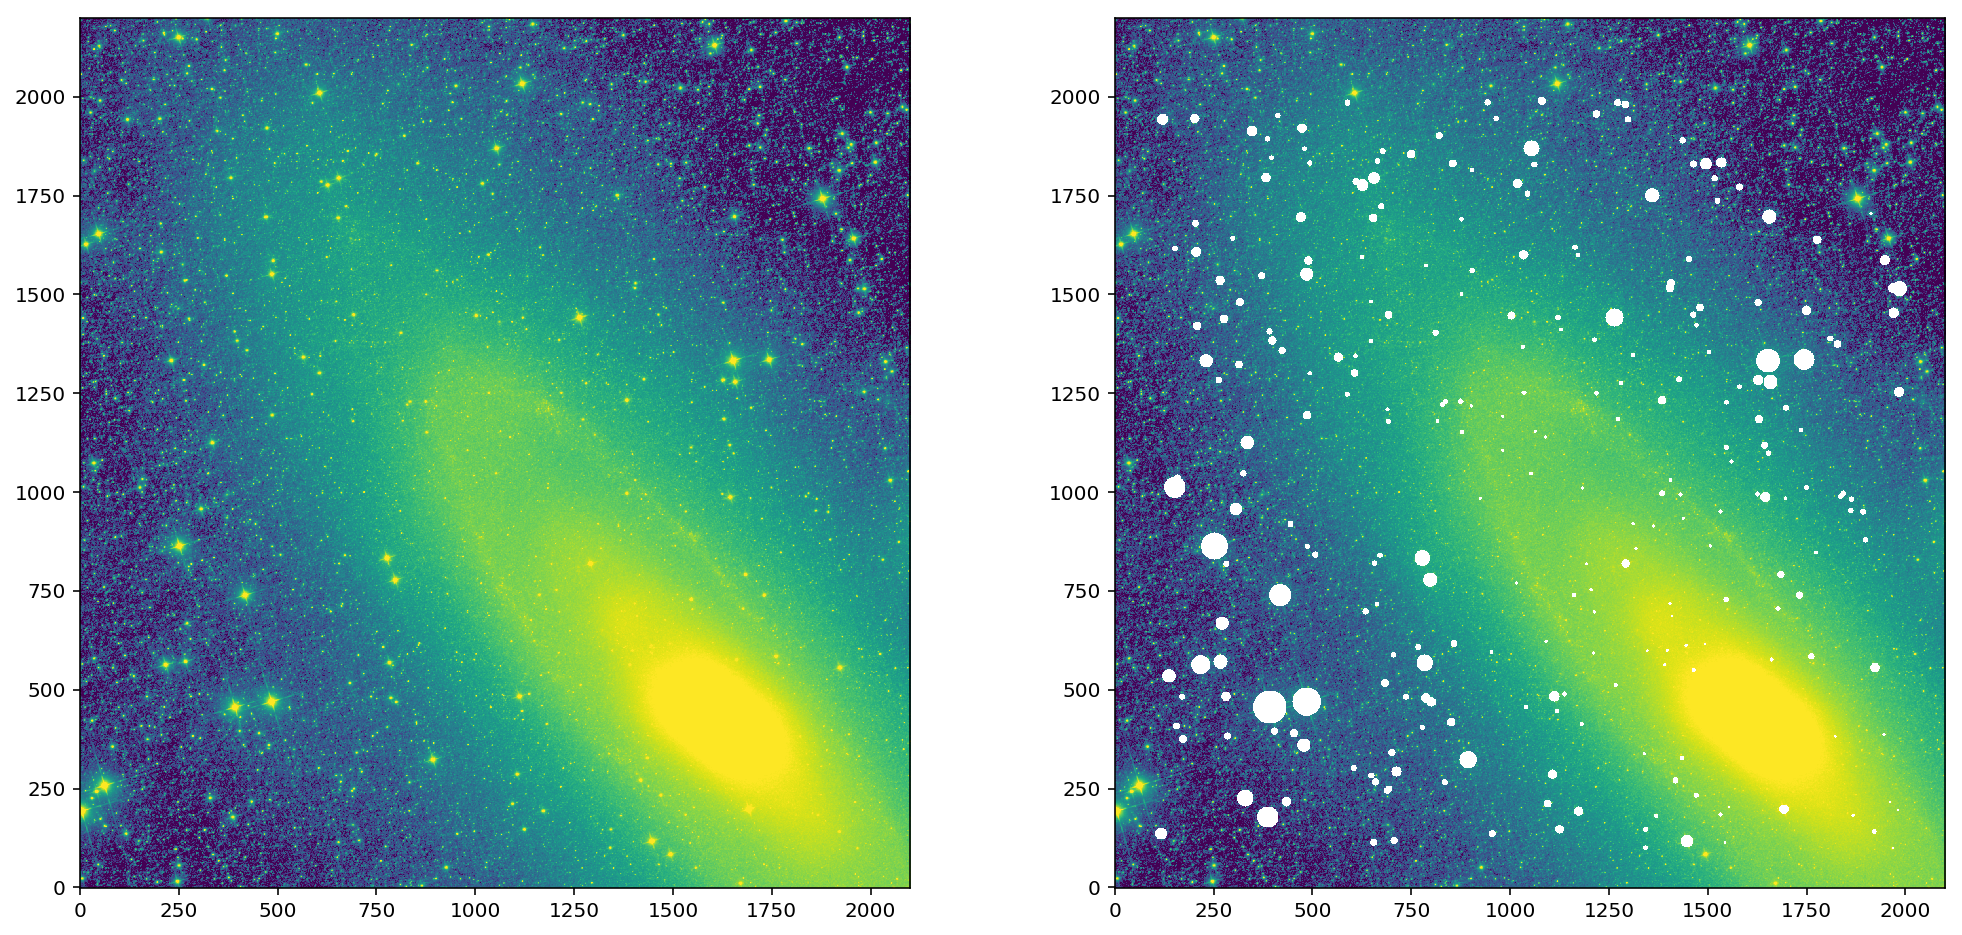

In [3]:
# trial run
fitsfile = 'unwise-custom-0107p412-w1-img-m.fits'
data = fits.getdata(fitsfile)
mask = make_masked_file(fitsfile, return_mask=True)
data_masked = data.copy()
data_masked[mask] = np.nan
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(17,8))
ax1.imshow(np.arcsinh(data[1700:3900,500:2600]), origin='lower', vmin=1, vmax=8)
ax2.imshow(np.arcsinh(data_masked[1700:3900,500:2600]), origin='lower', vmin=1, vmax=8)

In [4]:
fitslist = [f for f in glob.glob('*.fit*') if ('fgmask' not in f) & ('reproj' not in f)]

for f in fitslist:
    make_masked_file(f)

Making mask for unwise-custom-0107p412-w1-img-m.fits
Removing existing masked file
Made masked file unwise-custom-0107p412-w1-img-m_fgmask.fits
Making mask for m31_sdss_obs_flux_nomask_g.fits
Reducing radius for SDSS/g image by factor of 2
Removing existing masked file


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Made masked file m31_sdss_obs_flux_nomask_g_fgmask.fits
Making mask for m31_sdss_obs_flux_nomask_i.fits
Reducing radius for SDSS/i image by factor of 1.5
Removing existing masked file
Made masked file m31_sdss_obs_flux_nomask_i_fgmask.fits
Making mask for unwise-custom-0107p412-w2-img-m.fits
Removing existing masked file
Made masked file unwise-custom-0107p412-w2-img-m_fgmask.fits


In [5]:
# reprojections
import montage_wrapper as m
in_images = [i for i in glob.glob('*.fit*') if 'reproj' not in i]
out_images = [i.replace('.fit','_reproj.fit') for i in in_images]
m.reproject(in_images, out_images, header='sfhpixels_header.hdr')

INFO: Deleting work directory /var/folders/72/z00tr7ks3b5gmx_24dfmqmz40000gn/T/tmp4j9rspst [montage_wrapper.wrappers]


/Users/luxemburg/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/luxemburg/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


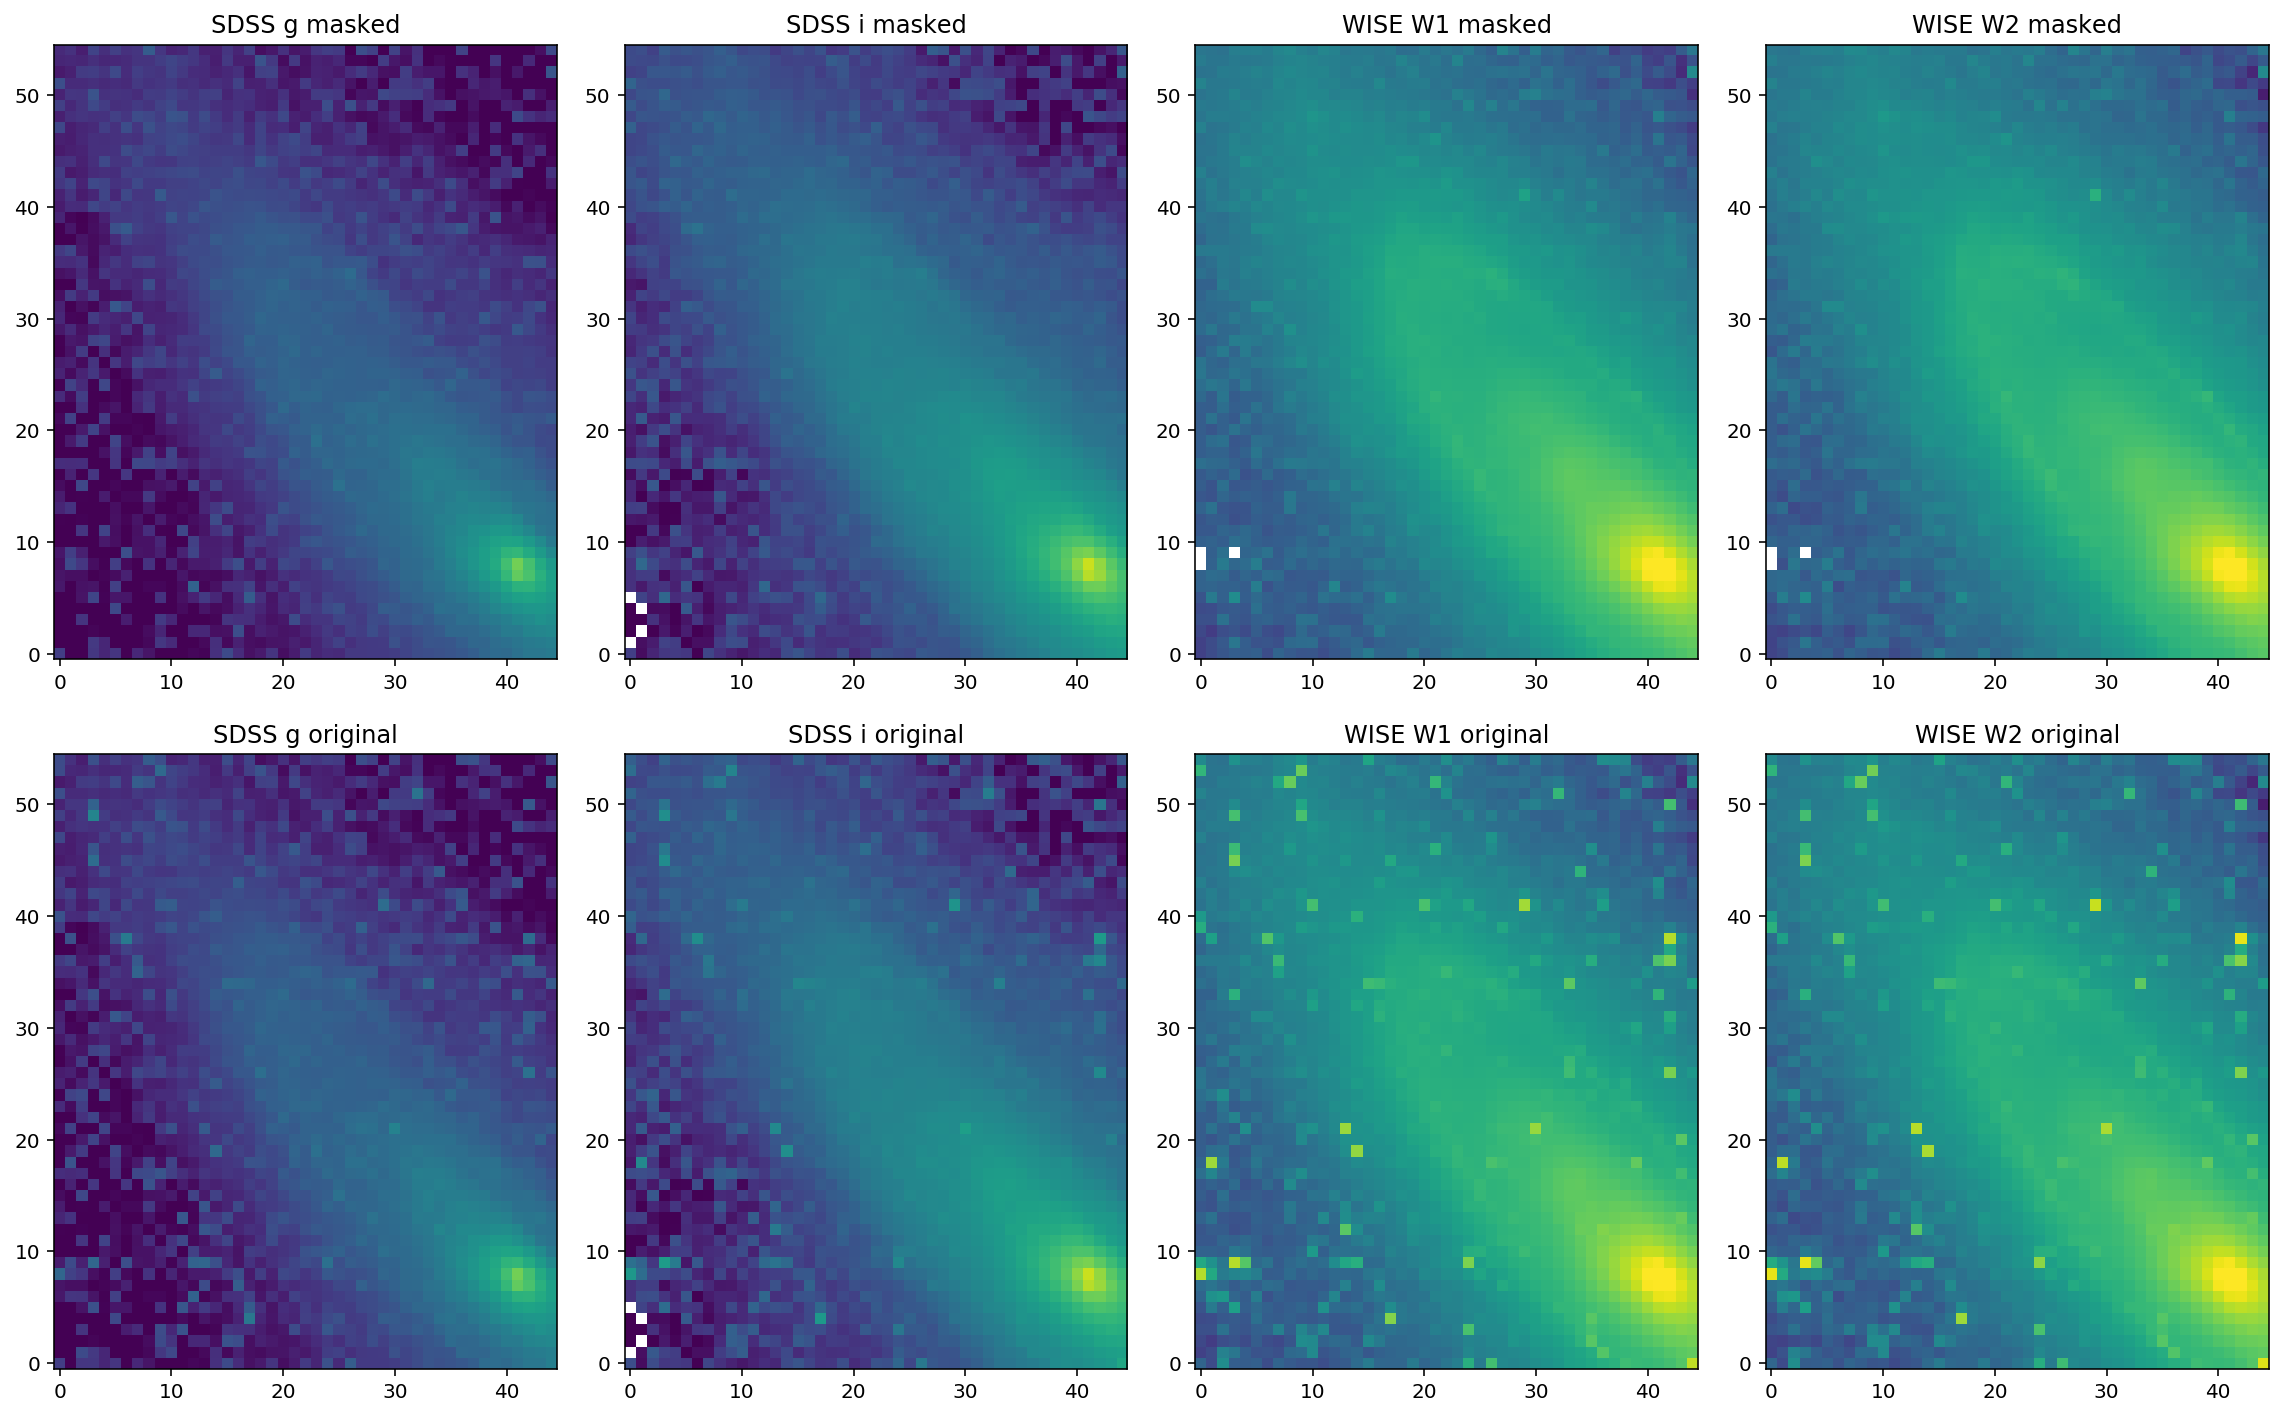

In [21]:
# compare reprojections
fig, axes = plt.subplots(2,4,figsize=(16,10))
top_im = ['m31_sdss_obs_flux_nomask_g_fgmask_reproj.fits',
          'm31_sdss_obs_flux_nomask_i_fgmask_reproj.fits',
          'unwise-custom-0107p412-w1-img-m_fgmask_reproj.fits',
          'unwise-custom-0107p412-w2-img-m_fgmask_reproj.fits']
bottom_im = [im.replace('_fgmask','') for im in top_im]

labels = ['SDSS g', 'SDSS i', 'WISE W1', 'WISE W2']

for i, ax in enumerate(axes[0]):
    ax.imshow(np.log10(fits.getdata(top_im[i]))[:,::-1], vmin=0, vmax=4, origin='lower')
    ax.set_title(labels[i] + ' masked')

for i, ax in enumerate(axes[1]):
    ax.imshow(np.log10(fits.getdata(bottom_im[i]))[:,::-1], vmin=0, vmax=4, origin='lower')
    ax.set_title(labels[i] + ' original')
fig.tight_layout()